<a href="https://colab.research.google.com/github/vieduy/CS114.K21/blob/master/face_mask_correctly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [52]:
!gdown --id 1bea1kfxQuGAf0nZycQcfFZDcHtCZf7ta

Downloading...
From: https://drive.google.com/uc?id=1bea1kfxQuGAf0nZycQcfFZDcHtCZf7ta
To: /content/test.zip
3.20MB [00:00, 50.7MB/s]


In [53]:
!gdown --id 1ucbjmTe0hdOt_Ke0VTx9kLJL6n7bjfCk

Downloading...
From: https://drive.google.com/uc?id=1ucbjmTe0hdOt_Ke0VTx9kLJL6n7bjfCk
To: /content/train.zip
15.6MB [00:00, 95.4MB/s]


In [ ]:
!unzip test.zip

In [ ]:
!unzip train.zip

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import random
import torchvision.transforms as transforms
import imageio

import glob
from PIL import Image
import cv2
import torch.nn as nn
from sklearn import svm
from torch.hub import load_state_dict_from_url
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

## Visualize dataset


# Create dataloader

In [56]:
class FM_Dataset(TensorDataset):
    def __init__(self, root):
        super(FM_Dataset, self).__init__()
        self.root = root
        self.labels = []
        self.img_paths = []
        self.transform =  transforms.Compose([
          transforms.ToPILImage(),
          transforms.ToTensor()])

        folder_path = glob.glob(root+'/*')
        for label_path in folder_path:
          self.img_paths.extend(glob.glob(label_path+'/*'))
        
        # print(self.img_paths[0])
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)
        img = np.resize(img, (227, 227, 3))
        img = self.transform(img)

        label = img_path.split('/')[-2]
        if label == 'incorrect':
          label = 0
        else:
          label = 1

        return img, label


    def __len__(self):
        return len(self.img_paths) 

# Initialize dataloader

In [57]:
train_dataset = FM_Dataset('face_mask_dataset')
trainset_loader = DataLoader(train_dataset,
                                 shuffle=False,
                                 batch_size=4,
                                 pin_memory=True,
                                #  drop_last=True
                                 )

# print(list(trainset_loader)[0][0][0])
#Now using the AlexNet
# AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

# Download AlexNet pretrained

In [58]:
import torchvision.models as models

AlexNet_model = models.alexnet(pretrained=True)

for param in AlexNet_model.parameters():
    param.requires_grad = False
AlexNet_model.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# __all__ = ['AlexNet', 'alexnet']


# model_urls = {
#     'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
# }


# class AlexNet(nn.Module):

#     def __init__(self, num_classes=1000):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), 256 * 6 * 6)
#         x = self.classifier(x)
#         return x


# def alexnet(pretrained=False, progress=True, **kwargs):
#     r"""AlexNet model architecture from the
#     `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#         progress (bool): If True, displays a progress bar of the download to stderr
#     """
#     model = AlexNet(**kwargs)
#     if pretrained:
#         state_dict = load_state_dict_from_url(model_urls['alexnet'],
#                                               progress=progress)
#         model.load_state_dict(state_dict)
#     return model


# # AlexNet_model_1 = AlexNet()
# # AlexNet_model_2 = AlexNet()
# AlexNet_model = AlexNet()
# state_dict = load_state_dict_from_url(model_urls['alexnet'],)
# # AlexNet_model_1.load_state_dict(state_dict)
# # AlexNet_model_2.load_state_dict(state_dict)

# # AlexNet_model_1.cuda()
# # AlexNet_model_2.cuda()

# #Model description
# # AlexNet_model.eval()

# Create 2 models 
- Model 1: Remove last FC
- Model 2: Remove 2 last FC

In [59]:
new_classifier = nn.Sequential(*list(AlexNet_model.classifier.children())[:-2])
AlexNet_model.classifier = new_classifier

In [ ]:
# new_classifier_1 = nn.Sequential(*list(AlexNet_model_1.classifier.children())[:-1])
# new_classifier_2 = nn.Sequential(*list(AlexNet_model_2.classifier.children())[:-2])
# AlexNet_model_1.classifier = new_classifier_1
# AlexNet_model_2.classifier = new_classifier_2

# Features extraction from 2 these models

In [60]:
features = []
labels = []

# loop over the dataset multiple times
for i, data in enumerate(trainset_loader):
  img, label = data[0].cuda(), data[1].cuda()
  with torch.no_grad():
    output = AlexNet_model(img)
    output = output.cpu()

    # if i == 0:
    #   print(img[0][0])
    #   print(output[0][0])
    features.extend(np.squeeze(output.data.numpy()))

    labels.extend(label.cpu().numpy())

print('Finished extracting features of AlexNet')

Finished extracting features of AlexNet


In [61]:
print(features[0])

[  0.58794993  -3.7071877   -0.35133108 ...  -4.0289917  -14.862189
   0.01714147]


In [ ]:
# features_1 = []
# features_2 = []
# labels = []

# for epoch in range(1):  # loop over the dataset multiple times
#     for _, data in enumerate(trainset_loader):
#         img, label = data[0].cuda(), data[1].cuda()

#         output_1 = AlexNet_model_1(img)
#         output_1 = output_1.cpu()
#         features_1.extend(np.squeeze(output_1.data.numpy()))

#         output_2 = AlexNet_model_2(img)
#         output_2 = output_2.cpu()
#         features_2.extend(np.squeeze(output_2.data.numpy()))
        
#         labels.extend(label.cpu().numpy())

# print('Finished extracting features of AlexNet')

Finished extracting features of AlexNet


In [ ]:
# #Updating the second classifier
# AlexNet_model.classifier[4] = nn.Linear(4096,4096)

# #Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
# AlexNet_model.classifier[6] = nn.Linear(1024,10)

In [62]:
print(np.shape(features))
print(np.shape(labels))

(160, 4096)
(160,)


## Create SVM model and train with 2 feature-map (80% training - 20% testing)

In [63]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(features, labels)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
# clf_1 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf_1.fit(features_1, labels)

# clf_2 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf_2.fit(features_2, labels)

# Compare accuracy between 2 models

In [64]:
test_dataset = FM_Dataset('test')

In [65]:
testset_loader = DataLoader(test_dataset,
                                 shuffle=False,
                                 batch_size=1,
                                 pin_memory=True
                                #  drop_last=True
                                 )

In [66]:
features_test = []
labels_test = []
 # loop over the dataset multiple times
for _, il in enumerate(testset_loader):
    image, label = il[0].cuda(), il[1].cuda()

    output = AlexNet_model(image)
    output = output.cpu()
    features_test.append(np.squeeze(output.data.numpy()))
    labels_test.append(label.cpu().numpy())

print('Finished extracting features of AlexNet')

Finished extracting features of AlexNet


In [67]:
print((features_test[0]))

[  0.61208904  -7.6072054    1.2467775  ...  -4.274523   -13.041966
  -1.9171482 ]


In [68]:
y_pre = clf.predict(features_test)

print(accuracy_score(y_pre, labels_test))

0.7


# Confusion matrix of model over 40 samples (20% testing) 

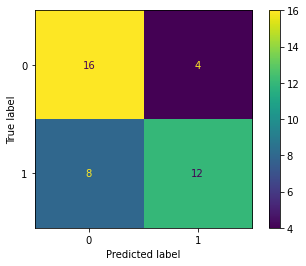

In [69]:
plot_confusion_matrix(clf, features_test, labels_test)
plt.show() 

In [ ]:
# y_pre_1 = clf_1.predict(features_test)
# y_pre_2 = clf_2.predict(features_test)

# print(accuracy_score(y_pre_1, labels_test))
# print(accuracy_score(y_pre_2, labels_test))

0.5
0.65


In [ ]:
from PIL import Image
from torch.autograd import Variable

# img_path = '../../pra2.jpg'
img_path = '../../201-with-mask.jpg'

img_pre = cv2.imread(img_path)
img = np.resize(img_pre, (227, 227, 3))

preprocess = transforms.Compose([
       transforms.ToPILImage(),
       transforms.ToTensor()
    ])
img_tensor = preprocess(img)
img_tensor.unsqueeze_(0)
img_var = Variable(img_tensor)
img_var = img_var.cuda()
out = AlexNet_model(img_var)

newOut = np.squeeze(out)
newOut = newOut.cpu()

newOut = torch.unsqueeze(newOut, 0)
pred = clf.predict(newOut.data.numpy())
print(pred)

[1]
